# Exploración redes neuronales con scikit-learn

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelado y validación
from sklearn.model_selection import (
    train_test_split,   
    StratifiedKFold,    
    GridSearchCV     
)

# Red neuronal
from sklearn.neural_network import MLPClassifier     

# Métricas
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# Preprocesamiento
from sklearn.utils import resample


# Configuración visual
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid", palette="muted", color_codes=True)

# Cargar dataset
df = pd.read_csv('../data/processed/diabetes_sample.csv')
print("Tamaño del dataset:", df.shape)
df.head()

Tamaño del dataset: (38052, 22)


,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,0.0,0.0,1.0,42.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,3.0,0.0,0.0,0.0,0.0,3.0,4.0,2.0
1,0.0,0.0,0.0,1.0,19.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,30.0,0.0,0.0,0.0,7.0,5.0,8.0
2,0.0,0.0,0.0,1.0,23.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,6.0,8.0
3,0.0,0.0,0.0,1.0,31.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
4,0.0,0.0,0.0,1.0,28.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,3.0,6.0,8.0


In [2]:
target_col = 'Diabetes_012'
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

print("Distribución de clases en train:\n", y_train.value_counts())

Distribución de clases en train:
 Diabetes_012
0.0    25643
2.0     4242
1.0      556
Name: count, dtype: int64


In [3]:
train_data = pd.concat([X_train, y_train], axis=1)

class0 = train_data[train_data['Diabetes_012'] == 0]
class1 = train_data[train_data['Diabetes_012'] == 1]
class2 = train_data[train_data['Diabetes_012'] == 2]

target_size = len(class2) * 3   
class0_down = resample(class0, replace=False, n_samples=target_size, random_state=2)

train_balanced = pd.concat([class0_down, class1, class2])

X_train_bal = train_balanced.drop('Diabetes_012', axis=1)
y_train_bal = train_balanced['Diabetes_012']

print("Distribución después del undersampling parcial:")
print(y_train_bal.value_counts())

Distribución después del undersampling parcial:
Diabetes_012
0.0    12726
2.0     4242
1.0      556
Name: count, dtype: int64


In [4]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=2)

model = MLPClassifier(
    max_iter=500,        
    random_state=2,
    early_stopping=True  
)

params = model.get_params()
print("\nParámetros del modelo MLP:")
for param, valor in sorted(params.items()):
    print(f"{param:25s} = {valor}")


Parámetros del modelo MLP:
activation                = relu
alpha                     = 0.0001
batch_size                = auto
beta_1                    = 0.9
beta_2                    = 0.999
early_stopping            = True
epsilon                   = 1e-08
hidden_layer_sizes        = (100,)
learning_rate             = constant
learning_rate_init        = 0.001
max_fun                   = 15000
max_iter                  = 500
momentum                  = 0.9
n_iter_no_change          = 10
nesterovs_momentum        = True
power_t                   = 0.5
random_state              = 2
shuffle                   = True
solver                    = adam
tol                       = 0.0001
validation_fraction       = 0.1
verbose                   = False
warm_start                = False


In [5]:
param_grid_mlp = {
    'hidden_layer_sizes': [
        (64,), (128,), (64,64),      
        (128,64,32),                 
        (32,16,8)                    
    ],
    'activation': ['relu', 'tanh'],   
    'solver': ['adam'],              
    'alpha': [0.0001, 0.001],         
    'learning_rate_init': [0.001, 0.01]  
}

grid_search_mlp = GridSearchCV(
    estimator=model,
    param_grid=param_grid_mlp,
    cv=cv,
    scoring='balanced_accuracy',
    n_jobs=-1,
    return_train_score=True
)

grid_search_mlp.fit(X_train_bal, y_train_bal)

,estimator,MLPClassifier...andom_state=2)
,param_grid,"{'activation': ['relu', 'tanh'], 'alpha': [0.0001, 0.001], 'hidden_layer_sizes': [(64,), (128,), ...], 'learning_rate_init': [0.001, 0.01], ...}"
,scoring,'balanced_accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,hidden_layer_sizes,"(32, ...)"


In [6]:
print("\nMejores parámetros encontrados:", grid_search_mlp.best_params_)
print("Mejor F1 macro en CV:", grid_search_mlp.best_score_)

best_model_mlp = grid_search_mlp.best_estimator_
print("\nMejor modelo entrenado:\n", best_model_mlp)


Mejores parámetros encontrados: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (32, 16, 8), 'learning_rate_init': 0.01, 'solver': 'adam'}
Mejor F1 macro en CV: 0.4625540297151107

Mejor modelo entrenado:
 MLPClassifier(activation='tanh', alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(32, 16, 8), learning_rate_init=0.01,
              max_iter=500, random_state=2)


In [7]:
results = pd.DataFrame(grid_search_mlp.cv_results_)

# Seleccionar columnas relevantes para MLP
columns_target = [
    'param_hidden_layer_sizes',
    'param_activation',
    'param_alpha',
    'param_learning_rate_init',
    'param_solver',
    'mean_train_score',
    'std_train_score',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]

# Subset ordenado por el ranking del score
results_subset = results[columns_target].copy()
results_subset = results_subset.sort_values(by='rank_test_score')

print("\nResultados resumidos de la búsqueda ordenados por score:")
print(results_subset.to_string(index=False))


Resultados resumidos de la búsqueda ordenados por score:
param_hidden_layer_sizes param_activation  param_alpha  param_learning_rate_init param_solver  mean_train_score  std_train_score  mean_test_score  std_test_score  rank_test_score
             (32, 16, 8)             tanh       0.0010                     0.010         adam          0.468344         0.007337         0.462554        0.014871                1
             (32, 16, 8)             relu       0.0010                     0.010         adam          0.460460         0.008949         0.456847        0.018626                2
                (64, 64)             tanh       0.0001                     0.010         adam          0.461544         0.010892         0.455313        0.011667                3
                  (128,)             relu       0.0010                     0.010         adam          0.460120         0.008135         0.455141        0.017091                4
                   (64,)             tanh      

Accuracy: 0.8369465247667849
Precision (macro): 0.44825333519081484
Recall (macro): 0.43482934905856546
F1-score (macro): 0.4398171789543777

Reporte de clasificación:
               precision    recall  f1-score   support

         0.0     0.8849    0.9318    0.9078      6412
         1.0     0.0000    0.0000    0.0000       139
         2.0     0.4598    0.3726    0.4117      1060

    accuracy                         0.8369      7611
   macro avg     0.4483    0.4348    0.4398      7611
weighted avg     0.8096    0.8369    0.8221      7611



c:\Users\Usuario\Desktop\Diabetes-Health-Indicators-predictions\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Usuario\Desktop\Diabetes-Health-Indicators-predictions\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Usuario\Desktop\Diabetes-Health-Indicators-predictions\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

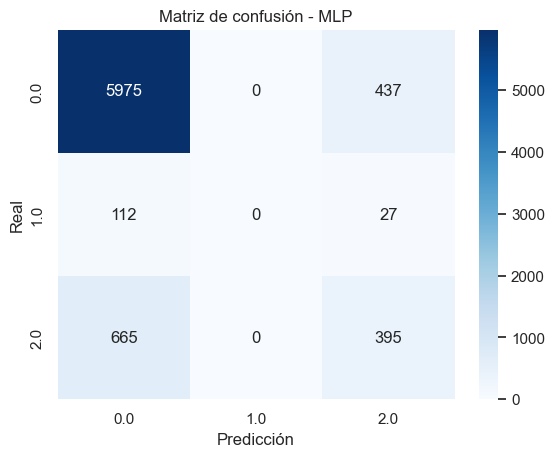

In [8]:
y_pred = best_model_mlp.predict(X_test)

# Métricas de evaluación
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision (macro):", precision_score(y_test, y_pred, average='macro'))
print("Recall (macro):", recall_score(y_test, y_pred, average='macro'))
print("F1-score (macro):", f1_score(y_test, y_pred, average='macro'))
print("\nReporte de clasificación:\n", classification_report(y_test, y_pred, digits=4))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt='d', cmap="Blues",
    xticklabels=np.unique(y_test),
    yticklabels=np.unique(y_test)
)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de confusión - MLP")
plt.show()